NumRawBeams:96


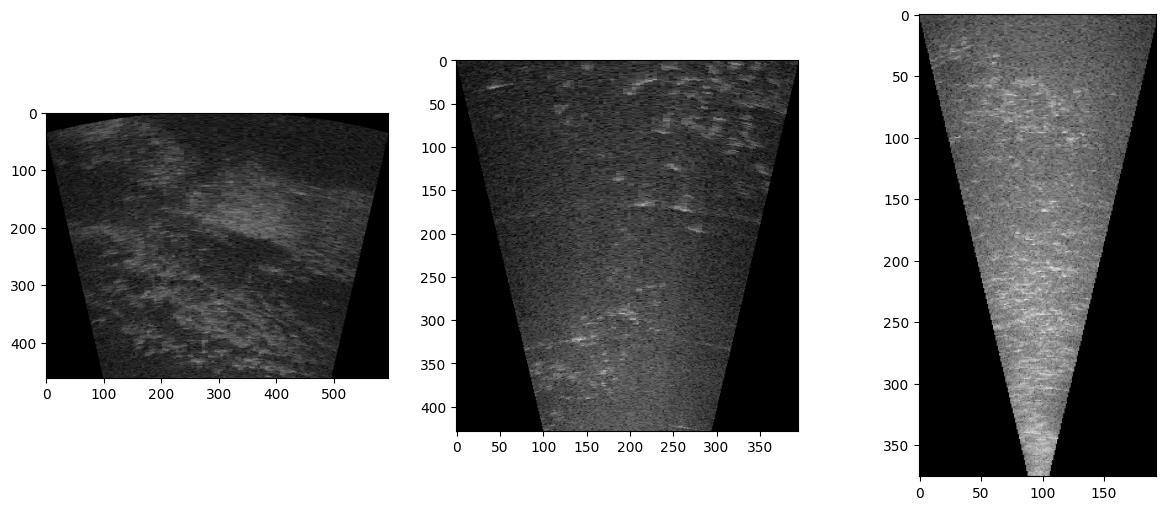

In [81]:
import cv2
import pyARIS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Crops the left and right black borders of the image
# This function check the entire column of the image from both left and right
def cropBlackBorder(img):
    leftX = 0
    rightX = img.shape[1] - 1

    for i in range(img.shape[1]):
        # check if the pixel is black
        if np.all(img[:, i] == 0):
            leftX += 1
        else:
            break
    
    for i in range(img.shape[1]):
        if np.all(img[:, rightX] == 0):
            rightX -= 1
        else:
            break

    return img[:, leftX:rightX]

# Crops the left and right black borders of the image
# This function only check the first row of the image
def cropBlackBorderFirstRow(img):
    leftX = 0
    rightX = img.shape[1] - 1

    for i in range(img.shape[1]):
        # check if the pixel is black
        if np.all(img[0, i] == 0):
            leftX += 1
        else:
            break
    
    for i in range(img.shape[1]):
        if np.all(img[0, rightX] == 0):
            rightX -= 1
        else:
            break

    return img[:, leftX:rightX]


def readARISFile(fileName):
    ARISdata, _ = pyARIS.DataImport(fileName)

    for i in range(ARISdata.FrameCount):
        frameData = pyARIS.FrameRead(ARISdata, i).remap
        convertedFrame = cv2.cvtColor(frameData, cv2.COLOR_GRAY2BGR)

        # crop the image into 3 equal parts
        segment1 = convertedFrame[:462,:]
        segment2 = convertedFrame[462:462+428,:]
        segment3 = convertedFrame[890:,:]

        plt.figure(figsize=(15, 6))
        plt.tight_layout()
        plt.subplot(131), plt.imshow(cropBlackBorder(segment1))
        plt.subplot(132), plt.imshow(cropBlackBorder(segment2))
        plt.subplot(133), plt.imshow(cropBlackBorderFirstRow(segment3))

        break

if __name__ == "__main__":
    fileName = r"./ARIS_2020_08_06/2020-08-06_215000.aris"
    readARISFile(fileName)